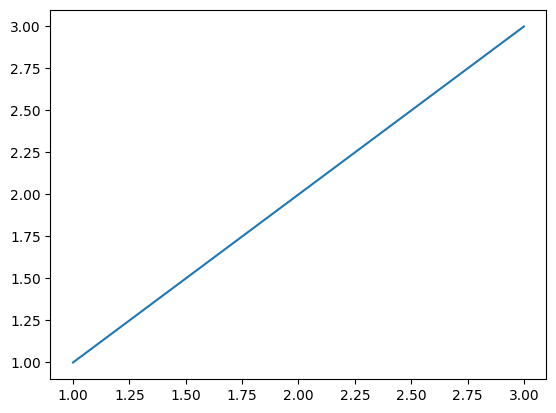

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.plot([1, 2, 3], [1, 2, 3])
plt.show()

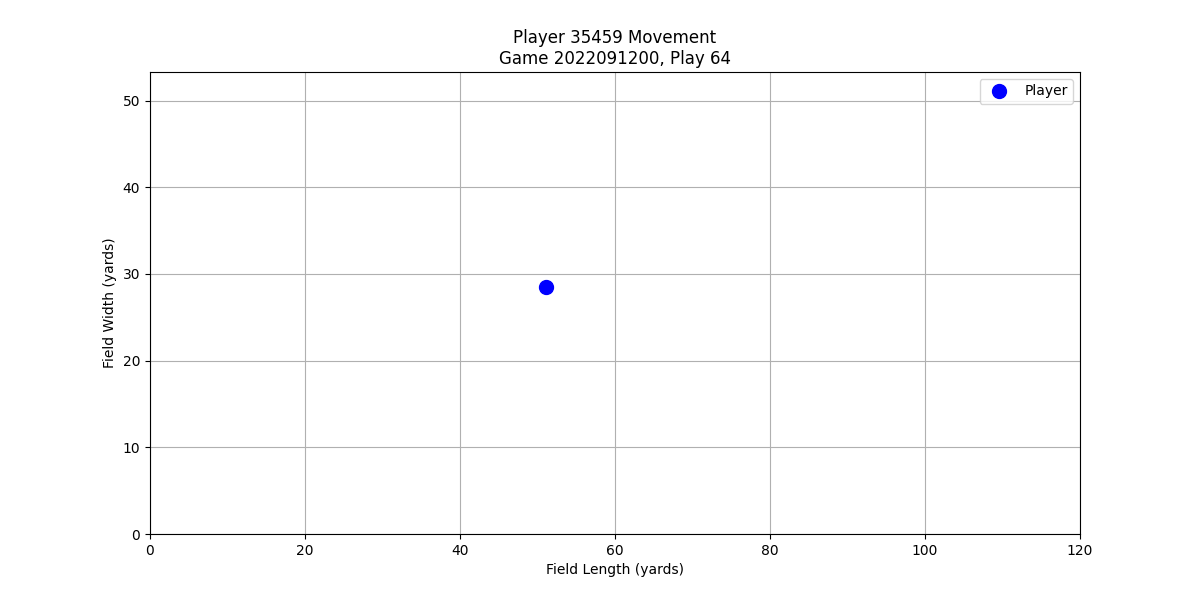

In [2]:
# First, make sure we're using the widget backend
%matplotlib widget

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

def animate_player_movement(df, nflId, gameId, playId):
    """
    Animate player movement on an NFL field
    """
    # Filter data
    player_data = df[(df['nflId'] == nflId) & 
                     (df['gameId'] == gameId) & 
                     (df['playId'] == playId)].copy()
    
    if len(player_data) == 0:
        raise ValueError("No data found for the specified player, game, and play combination")
    
    # Extract coordinates
    x_coords = player_data['x'].values
    y_coords = player_data['y'].values
    frames = player_data['frameId'].values
    
    # Create the figure with widget backend
    plt.ioff()  # Turn off interactive mode
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Set up the field
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.grid(True)
    ax.set_title(f"Player {nflId} Movement\nGame {gameId}, Play {playId}")
    ax.set_xlabel("Field Length (yards)")
    ax.set_ylabel("Field Width (yards)")
    
    # Initialize player position and trail
    player_dot, = ax.plot([x_coords[0]], [y_coords[0]], 'bo', markersize=10, label='Player')
    trail, = ax.plot([], [], 'b-', alpha=0.3)
    trail_length = 10
    
    def init():
        player_dot.set_data([x_coords[0]], [y_coords[0]])
        trail.set_data([], [])
        return player_dot, trail
    
    def update(frame_idx):
        # Update player position
        current_x = x_coords[frame_idx]
        current_y = y_coords[frame_idx]
        player_dot.set_data([current_x], [current_y])
        
        # Update trail
        start_idx = max(0, frame_idx - trail_length)
        trail.set_data(x_coords[start_idx:frame_idx + 1], 
                      y_coords[start_idx:frame_idx + 1])
        
        return player_dot, trail
    
    # Create the animation with explicit frames
    anim = FuncAnimation(fig, update,
                        init_func=init,
                        frames=range(len(frames)),
                        blit=True,
                        interval=100,
                        repeat=True)
    
    ax.legend()
    
    # Instead of plt.close(), show the figure
    plt.show()
    return fig

# Example usage:
try:
    # Load the data
    df = pd.read_csv('tracking_week_1.csv')
    
    # Create and display the animation
    fig = animate_player_movement(df, nflId=35459, gameId=2022091200, playId=64)
    
except FileNotFoundError:
    print("Error: tracking_week_1.csv file not found. Please check the file path.")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

def init_player_markers(ax, unique_players, play_data):
    player_markers = {}
    team_colors = {
        'DEN': 'orange', 'SEA': 'green', 'TB': 'red', 'DAL': 'navy',
        'TEN': 'lightblue', 'NYG': 'blue', 'MIN': 'purple', 'GB': 'green',
        'LV': 'black', 'LAC': 'yellow', 'KC': 'red', 'ARI': 'darkred',
        'JAX': 'teal', 'WAS': 'burgundy', 'NYJ': 'green', 'BAL': 'purple',
        'MIA': 'aqua', 'NE': 'navy', 'IND': 'blue', 'HOU': 'darkblue',
        'PHI': 'darkgreen', 'DET': 'blue', 'CIN': 'orange', 'PIT': 'yellow',
        'SF': 'red', 'CHI': 'darkorange', 'CLE': 'brown', 'CAR': 'lightblue',
        'NO': 'black', 'ATL': 'red', 'BUF': 'blue', 'LA': 'blue'
    }
    football_color = 'brown'

    try:
        for player_id in unique_players:
            if pd.isna(player_id):
                player_markers[player_id] = ax.plot([], [], 'o', color=football_color, 
                                                  markersize=10, label='Football')[0]
            else:
                # Handle potential KeyError if player's team is not found
                player_data = play_data[play_data['nflId'] == player_id]
                if not player_data.empty:
                    team = player_data['club'].iloc[0]
                    color = team_colors.get(team, 'gray')  # Use gray as fallback color
                    player_markers[player_id] = ax.plot([], [], 'o', color=color)[0]
        
        return player_markers
    except Exception as e:
        print(f"Error initializing player markers: {str(e)}")
        raise

def update_player_positions(frame, play_data, player_markers):
    try:
        current_frame_data = play_data[play_data['frameId'] == frame]
        
        for player_id, marker in player_markers.items():
            player_data = current_frame_data[
                pd.isna(current_frame_data['nflId']) if pd.isna(player_id) 
                else (current_frame_data['nflId'] == player_id)
            ]
            
            if not player_data.empty:
                x, y = player_data['x'].iloc[0], player_data['y'].iloc[0]
                marker.set_data(x, y)
        
        return list(player_markers.values())
    except Exception as e:
        print(f"Error updating positions for frame {frame}: {str(e)}")
        return []

def animate_play(df, gameId, playId):
    try:
        # Input validation
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input 'df' must be a pandas DataFrame")
        
        required_columns = ['gameId', 'playId', 'frameId', 'nflId', 'x', 'y', 'club']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"DataFrame missing required columns: {missing_columns}")
        
        # Filter data
        play_data = df[(df['gameId'] == gameId) & (df['playId'] == playId)]
        if play_data.empty:
            raise ValueError(f"No data found for game {gameId}, play {playId}")
        
        # Extract unique players
        unique_players = play_data['nflId'].unique()
        
        # Set up the plot
        plt.style.use('dark_background')  # Better visibility
        fig, ax = plt.subplots(figsize=(15, 8))
        ax.set_xlim(0, 120)
        ax.set_ylim(0, 53.3)
        ax.set_title(f"Game {gameId}, Play {playId} - Player Movement", pad=15)
        ax.grid(True, alpha=0.3)
        
        # Add field markers
        for i in range(0, 120, 10):
            ax.axvline(x=i, color='white', alpha=0.2)
            ax.text(i + 5, 2, str(i), ha='center', color='white', alpha=0.5)
        
        # Initialize markers
        player_markers = init_player_markers(ax, unique_players, play_data)
        
        # Create animation
        anim = FuncAnimation(
            fig, 
            update_player_positions,
            frames=sorted(play_data['frameId'].unique()),
            fargs=(play_data, player_markers),
            blit=True,
            interval=100,
            repeat=True
        )
        
        plt.tight_layout()
        plt.show()
        return anim
        
    except Exception as e:
        print(f"Error in animate_play: {str(e)}")
        plt.close()  # Clean up any partial figure
        raise

In [3]:
df = pd.read_csv("tracking_week_1.csv")

Error updating positions for frame 1: x must be a sequence
Error updating positions for frame 1: x must be a sequence


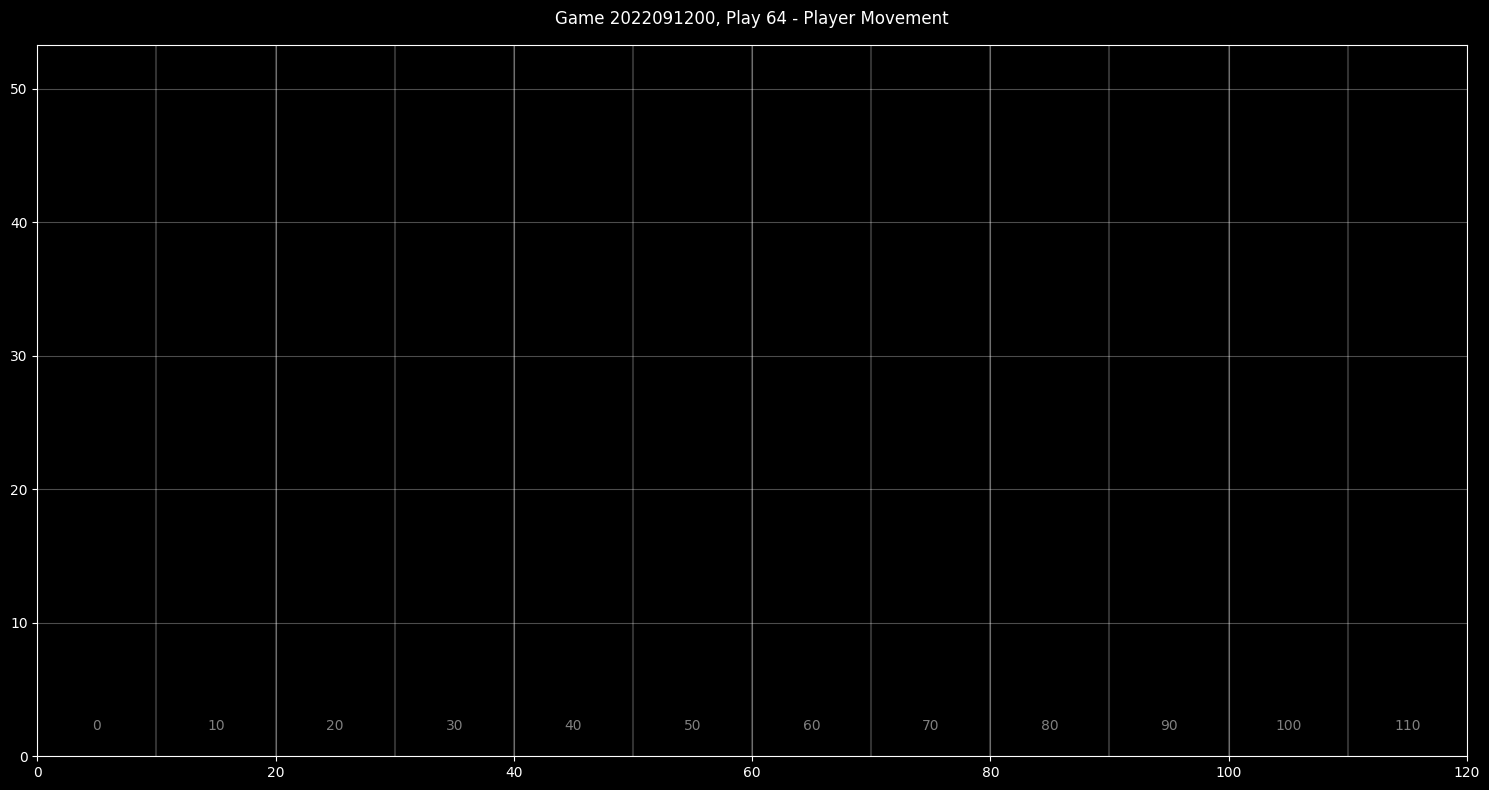

In [4]:
animate_play(df, gameId=2022091200, playId=64)

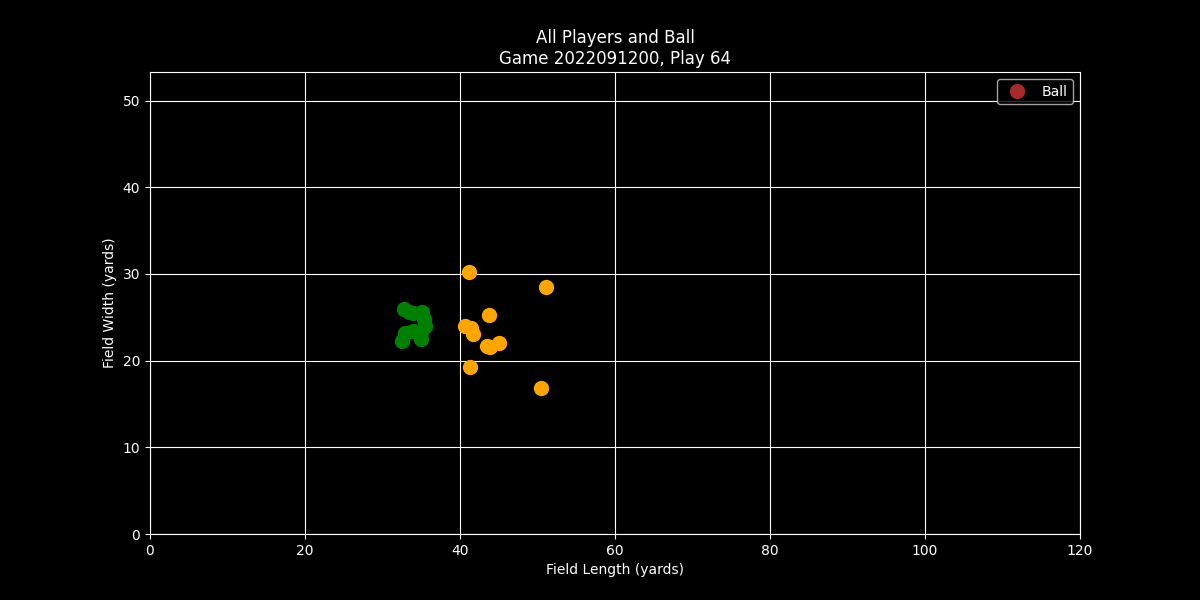

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

team_colors = {
    'DEN': 'orange',
    'SEA': 'green',
    'football': 'brown',  # Special case for the football
    'TB': 'red',
    'DAL': 'navy',
    'TEN': 'lightblue',
    'NYG': 'blue',
    'MIN': 'purple',
    'GB': 'green',
    'LV': 'black',
    'LAC': 'yellow',
    'KC': 'red',
    'ARI': 'darkred',
    'JAX': 'teal',
    'WAS': 'burgundy',
    'NYJ': 'green',
    'BAL': 'purple',
    'MIA': 'aqua',
    'NE': 'navy',
    'IND': 'blue',
    'HOU': 'darkblue',
    'PHI': 'darkgreen',
    'DET': 'blue',
    'CIN': 'orange',
    'PIT': 'yellow',
    'SF': 'red',
    'CHI': 'darkorange',
    'CLE': 'brown',
    'CAR': 'lightblue',
    'NO': 'black',
    'ATL': 'red',
    'BUF': 'blue',
    'LA': 'blue'
}

class NFLFieldAnimation:
    def __init__(self, df):
        self.df = df
        self.unique_nflids = df['nflId'].unique()
        self.unique_gameids = df['gameId'].unique()
        self.unique_playids = df['playId'].unique()

    def animate_all_players(self, gameId, playId):
        """
        Animate the movement of all players and the ball on an NFL field.
        """
        play_data = self.df[(self.df['gameId'] == gameId) & 
                           (self.df['playId'] == playId)].copy()

        if len(play_data) == 0:
            raise ValueError(f"No data found for gameId={gameId}, playId={playId}")

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xlim(0, 120)
        ax.set_ylim(0, 53.3)
        ax.grid(True)
        ax.set_title(f"All Players and Ball\nGame {gameId}, Play {playId}")
        ax.set_xlabel("Field Length (yards)")
        ax.set_ylabel("Field Width (yards)")

        player_dots = {}
        player_trails = {}
        ball_dot, = ax.plot([], [], 'ro', markersize=10, label='Ball')
        ball_trail, = ax.plot([], [], 'r-', alpha=0.3)
        trail_length = 10

        for nflId in self.unique_nflids:
            player_data = play_data[play_data['nflId'] == nflId]
            if len(player_data) > 0:
                x_coords = player_data['x'].values
                y_coords = player_data['y'].values
                club = player_data['club'].values[0]
                color = team_colors.get(club, 'black')  # Use 'black' as the default color
                player_dots[nflId], = ax.plot([x_coords[0]], [y_coords[0]], color=color, marker='o', markersize=10)
                player_trails[nflId], = ax.plot([], [], color=color, linestyle='-', alpha=0.3)

        ball_data = play_data[play_data['nflId'].isna()].copy()
        if len(ball_data) > 0:
            ball_x_coords = ball_data['x'].values
            ball_y_coords = ball_data['y'].values
            ball_dot.set_color(team_colors.get('football', 'brown'))

        def init():
            ball_dot.set_data([], [])
            ball_trail.set_data([], [])
            for nflId in player_dots:
                player_dots[nflId].set_data([player_data['x'].values[0]], [player_data['y'].values[0]])
                player_trails[nflId].set_data([], [])
            return ball_dot, ball_trail, *player_dots.values(), *player_trails.values()

        def update(frame_idx):
            ball_dot.set_data([ball_x_coords[frame_idx]], [ball_y_coords[frame_idx]])

            start_idx = max(0, frame_idx - trail_length)
            ball_trail.set_data(ball_x_coords[start_idx:frame_idx + 1], 
                               ball_y_coords[start_idx:frame_idx + 1])

            for nflId in player_dots:
                player_data = play_data[play_data['nflId'] == nflId]
                player_x_coords = player_data['x'].values
                player_y_coords = player_data['y'].values
                player_dots[nflId].set_data([player_x_coords[frame_idx]], [player_y_coords[frame_idx]])

                start_idx = max(0, frame_idx - trail_length)
                player_trails[nflId].set_data(player_x_coords[start_idx:frame_idx + 1], 
                                             player_y_coords[start_idx:frame_idx + 1])

            return ball_dot, ball_trail, *player_dots.values(), *player_trails.values()

        anim = FuncAnimation(fig, update,
                            init_func=init,
                            frames=range(len(ball_data)),
                            blit=True,
                            interval=100,
                            repeat=True)

        ax.legend()
        plt.show()
        return fig

# Example usage
try:
    df = pd.read_csv('tracking_week_1.csv')
    animation = NFLFieldAnimation(df)

    # Animate all players and the ball
    fig = animation.animate_all_players(gameId=2022091200, playId=64)

except FileNotFoundError:
    print("Error: tracking_week_1.csv file not found. Please check the file path.")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()